In [40]:
# benchmark.ipynb
# Part of the aflplusplus project, requires an ipynb (Jupyter) editor or viewer.
# Author: Chris Ball <chris@printf.net>
import json
import pandas as pd
with open("benchmark-results.jsonl") as f:
    lines = f.read().splitlines()
json_lines = [json.loads(line) for line in lines]


### Translate the JSON Lines entries into a single pandas DataFrame

We have JSON Lines in [benchmark-results.jsonl](benchmark-results.jsonl) that look like this:

In [41]:
print(json.dumps(json.loads(lines[0]), indent=2))

{
  "config": {
    "afl_persistent_config": true,
    "afl_system_config": true,
    "afl_version": "++4.09a",
    "comment": "i9-9900k, 16GB DDR4-3000, Arch Linux",
    "compiler": "clang version 15.0.7",
    "target_arch": "x86_64-pc-linux-gnu"
  },
  "hardware": {
    "cpu_fastest_core_mhz": 4999.879,
    "cpu_model": "Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz",
    "cpu_threads": 16
  },
  "targets": {
    "test-instr": {
      "multicore": {
        "afl_execs_per_sec": 11025.88,
        "afl_execs_total": 519670,
        "fuzzers_used": 1,
        "run_end": "2023-09-24 01:18:19.516294",
        "run_start": "2023-09-24 01:17:55.982600",
        "total_execs_per_sec": 11019.3,
        "total_run_time": 47.16
      }
    },
    "test-instr-persist-shmem": {
      "multicore": {
        "afl_execs_per_sec": 134423.5,
        "afl_execs_total": 519670,
        "fuzzers_used": 1,
        "run_end": "2023-09-24 01:17:32.262373",
        "run_start": "2023-09-24 01:17:30.328037",
     

The [pd.json_normalize()](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html]) method translates this into a flat table that we can perform queries against:

In [42]:

df = pd.json_normalize(json_lines)
df.head()

,config.afl_persistent_config,config.afl_system_config,config.afl_version,config.comment,config.compiler,config.target_arch,hardware.cpu_fastest_core_mhz,hardware.cpu_model,hardware.cpu_threads,targets.test-instr.multicore.afl_execs_per_sec,...,targets.test-instr.singlecore.run_start,targets.test-instr.singlecore.total_execs_per_sec,targets.test-instr.singlecore.total_run_time,targets.test-instr-persist-shmem.singlecore.afl_execs_per_sec,targets.test-instr-persist-shmem.singlecore.afl_execs_total,targets.test-instr-persist-shmem.singlecore.fuzzers_used,targets.test-instr-persist-shmem.singlecore.run_end,targets.test-instr-persist-shmem.singlecore.run_start,targets.test-instr-persist-shmem.singlecore.total_execs_per_sec,targets.test-instr-persist-shmem.singlecore.total_run_time
0,True,True,++4.09a,"i9-9900k, 16GB DDR4-3000, Arch Linux",clang version 15.0.7,x86_64-pc-linux-gnu,4999.879,Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz,16,11025.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,++4.09a,"i9-9900k, 16GB DDR4-3000, Arch Linux",clang version 15.0.7,x86_64-pc-linux-gnu,4998.794,Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz,16,21139.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,True,++4.09a,"i9-9900k, 16GB DDR4-3000, Arch Linux",clang version 15.0.7,x86_64-pc-linux-gnu,4998.859,Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz,16,30618.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,++4.09a,"i9-9900k, 16GB DDR4-3000, Arch Linux",clang version 15.0.7,x86_64-pc-linux-gnu,5000.078,Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz,16,39125.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,True,++4.09a,"i9-9900k, 16GB DDR4-3000, Arch Linux",clang version 15.0.7,x86_64-pc-linux-gnu,4996.885,Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz,16,47861.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Graph prep

We're looking for a line graph showing lines for each fuzz target, in both singlecore and multicore modes, in each config setting -- where the x-axis is number of cores, and the y-axis is either afl_execs_per_sec or total_execs_per_sec (I'm not yet sure which is a better metric to use).

But first, a mini test harness by checking that the number of rows matched what we'd intuitively expect:

In [43]:
i7 = df.query("`config.comment` == 'i9-9900k, 16GB DDR4-3000, Arch Linux'")
assert len(i7) == 148
multicore  = i7.query("`targets.test-instr-persist-shmem.multicore.total_execs_per_sec` > 0 or `targets.test-instr.multicore.total_execs_per_sec` > 0")
assert len(multicore) == 144 # 36 cores * 4 states * 1 run (containing two targets)
singlecore = i7.query("`targets.test-instr-persist-shmem.singlecore.total_execs_per_sec` > 0 or `targets.test-instr.singlecore.total_execs_per_sec` > 0")
assert len(singlecore) == 4 # 1 core * 4 states * 1 run (containing two targets)

In [44]:
def build_graphdf_from_query(query: pd.DataFrame):
    """Build a table suitable for graphing from a subset of the dataframe."""
    graphdata = []
    max_fuzzers = int(query[["targets.test-instr-persist-shmem.multicore.fuzzers_used", "targets.test-instr.multicore.fuzzers_used"]].max(axis=1).max(axis=0))
    for _, row in query.iterrows():
        for target in ["test-instr-persist-shmem", "test-instr"]:
            for mode in ["multicore", "singlecore"]:
                label = ""
                if not row[f"targets.{target}.{mode}.total_execs_per_sec"] > 0:
                    continue
                execs_per_sec         = row[f"targets.{target}.{mode}.total_execs_per_sec"]
                afl_execs_per_sec     = row[f"targets.{target}.{mode}.afl_execs_per_sec"]
                parallel_fuzzers      = row[f"targets.{target}.{mode}.fuzzers_used"]
                afl_persistent_config = row["config.afl_persistent_config"]
                afl_system_config     = row["config.afl_system_config"]
                if target == "test-instr-persist-shmem":
                    label += "shmem"
                else:
                    label += "base"
                if mode == "multicore":
                    label += "-multicore"
                else:
                    label += "-singlecore"
                if afl_persistent_config:
                    label += "+persist-conf"
                if afl_system_config:
                    label += "+system-conf"
    
                if label == "shmem-multicore+persist-conf+system-conf":
                    graphdata.append({"execs_per_sec": execs_per_sec, "parallel_fuzzers": parallel_fuzzers, "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Multicore: Persistent mode/shared memory + kernel config"})
                    graphdata.append({"execs_per_sec": afl_execs_per_sec, "parallel_fuzzers": parallel_fuzzers, "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Multicore: afl_execs: Persistent mode/shared memory + kernel config"})
                if label == "shmem-multicore":
                    graphdata.append({"execs_per_sec": execs_per_sec, "parallel_fuzzers": parallel_fuzzers, "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Multicore: Persistent mode/shared memory without kernel config"})
                if label == "base-multicore+persist-conf+system-conf":
                    graphdata.append({"execs_per_sec": execs_per_sec, "parallel_fuzzers": parallel_fuzzers, "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Multicore: Non-persistent mode + kernel config"})
                if label == "shmem-singlecore+persist-conf+system-conf":
                    for i in range(1, max_fuzzers + 1):
                        graphdata.append({"execs_per_sec": execs_per_sec, "parallel_fuzzers": float(i), "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Singlecore: Persistent mode/shared memory + kernel config"})
                if label == "base-singlecore+persist-conf+system-conf":
                    for i in range(1, max_fuzzers + 1):
                        graphdata.append({"execs_per_sec": execs_per_sec, "parallel_fuzzers": float(i), "afl_persistent_config": afl_persistent_config, "afl_system_config": afl_system_config, "label": "Singlecore: Non-persistent mode + kernel config"})
    return pd.DataFrame.from_records(graphdata).sort_values("label", ascending=False)

graphdf = build_graphdf_from_query(i7)

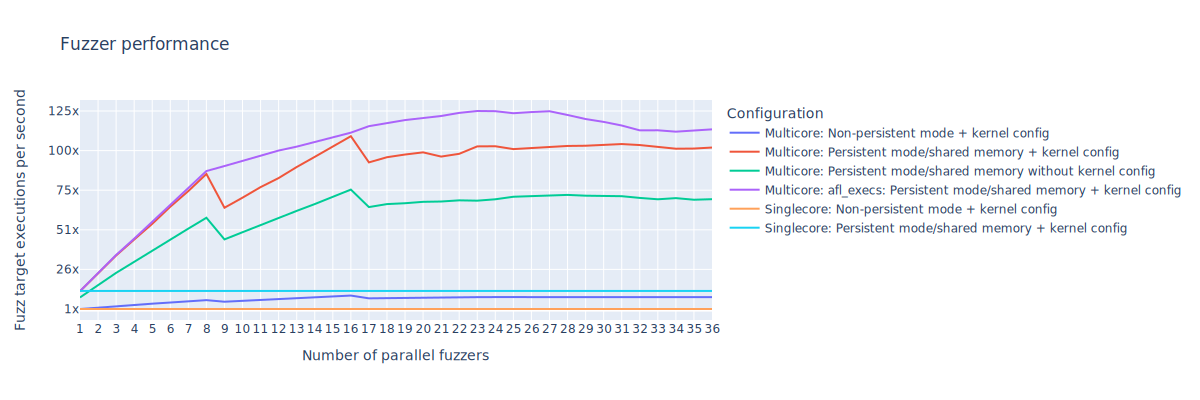

In [45]:
import numpy as np
pd.options.plotting.backend = "plotly"

# Right now our table has absolute values of execs per sec, but it's more useful
# to show relative perf (vs 1.0x baseline)
pivotdf = graphdf.pivot(index="parallel_fuzzers", columns="label", values="execs_per_sec")
fig = pivotdf.plot(
    title="Fuzzer performance",
    labels={
        "label": "Configuration",
        "parallel_fuzzers": "Number of parallel fuzzers",
        "value": "Fuzz target executions per second"
    }
)

# Compute tick values and their labels for the primary Y-axis
tickvals = np.linspace(graphdf['execs_per_sec'].min(), graphdf['execs_per_sec'].max(), 6)
ticktext = [f"{val:.0f}x" for val in tickvals / graphdf['execs_per_sec'].min()]
# Update the primary Y-axis with custom tick labels
fig.update_yaxes(tickvals=tickvals, ticktext=ticktext)
fig.update_xaxes(tickvals=list(range(1,36+1)))
fig.update_layout(width=1200, height=400)
fig.show("svg")


Here's what the table that produced this graph looks like:

In [46]:
pivotdf.head()

label,Multicore: Non-persistent mode + kernel config,Multicore: Persistent mode/shared memory + kernel config,Multicore: Persistent mode/shared memory without kernel config,Multicore: afl_execs: Persistent mode/shared memory + kernel config,Singlecore: Non-persistent mode + kernel config,Singlecore: Persistent mode/shared memory + kernel config
parallel_fuzzers,,,,,,
1.0,11019.30,133591.26,90851.40,134423.50,11038.96,135613.26
2.0,21111.92,255995.07,176159.32,258490.04,11038.96,135613.26
3.0,30568.82,380246.34,260268.78,383777.45,11038.96,135613.26
4.0,38963.07,490254.72,336355.99,496249.48,11038.96,135613.26
5.0,47693.65,598698.16,413750.00,613089.31,11038.96,135613.26


You can totally ignore the code cell directly below (unless you're curious).  It's just preparing Markdown for the block below it to render.  Jupyter Notebooks aren't able to use code variables inside Markdown blocks, so I have to do this instead.

In [47]:
# (Ignore this code cell.)
from IPython.display import Markdown as md
singlecore_base_execs = pivotdf.iloc[0]["Singlecore: Non-persistent mode + kernel config"]
singlecore_persist_execs = pivotdf.iloc[0]["Singlecore: Persistent mode/shared memory + kernel config"]
multicore_fuzzers_with_afl_max_execs = int(pivotdf["Multicore: afl_execs: Persistent mode/shared memory + kernel config"].idxmax())
multicore_fuzzers_with_total_max_execs = int(pivotdf["Multicore: Persistent mode/shared memory + kernel config"].idxmax())
multicore_base_max_execs = pivotdf["Multicore: Non-persistent mode + kernel config"].max()
factor_for_execs = lambda execs: round(execs / singlecore_base_execs, 1)

multicore_persistent_without_mitigations_label = "Multicore: Persistent mode/shared memory + kernel config"
multicore_max_execs_mitigations_off = pivotdf[multicore_persistent_without_mitigations_label].max()
multicore_max_execs_mitigations_off_only_cores = pivotdf.loc[multicore_fuzzers_with_total_max_execs / 2][multicore_persistent_without_mitigations_label]
multicore_max_execs_mitigations_on = pivotdf["Multicore: Persistent mode/shared memory without kernel config"].max()
multicore_avg_gain_per_core = pivotdf.loc[pivotdf.index <= 8]["Multicore: Persistent mode/shared memory + kernel config"].diff().dropna().mean()
mitigations_off_increase = int(multicore_max_execs_mitigations_off - multicore_max_execs_mitigations_on)

md(f"""
### Line graph analysis
Here are a few things that jump out from the graph above.  Let's start at the bottom of the graph.

#### test-instr vs. test-instr-persist-shmem

This graph is scaled so that the single-core, non-persistent-mode performance ({int(singlecore_base_execs)} execs per second) is
represented as **1.0x**.  If you build and run a fuzzer without creating a persistent mode harness for it, and without running fuzzers in parallel, this is the performance
you get on this machine.

#### Multicore test-instr

By running as many parallel fuzzers are there are CPU threads, we can reach {int(multicore_base_max_execs)} execs per second, which is **{factor_for_execs(multicore_base_max_execs)}x** that base speed.

#### Persistent mode + shared memory

##### Singlecore

By modifying the harness to use persistent mode with shared memory as described [here](https://github.com/AFLplusplus/AFLplusplus/blob/stable/instrumentation/README.persistent_mode.md#4-persistent-mode),
we end up with **{factor_for_execs(singlecore_persist_execs)}x** base speed.  So -- perhaps counter-intuively -- if you have a choice between switching to using multiple cores or rewriting
the harness to use persistent mode on a single core, it is better (at least on this machine) to use persistent mode on a single core, than to use non-persistent mode on all cores.

##### Multicore

By scaling up that persistent mode with shared memory harness across cores, and with kernel mitigations still turned on (see next section), we get to
**{factor_for_execs(multicore_max_execs_mitigations_on)}x** base speed.

#### Kernel config

By "kernel config", I'm referring to booting the Linux kernel with `mitigations=off`, which is a meta-parameter for disabling *all* hardware vulnerability meltdowns (such as Spectre,
Meltdown, Retbleed, etc) introduced in Linux v5.2.  Disabling these results in a `total_execs_per_sec` increase of {mitigations_off_increase} execs -- the difference between
{factor_for_execs(multicore_max_execs_mitigations_off)}x (mitigations off) and {factor_for_execs(multicore_max_execs_mitigations_on)}x (mitigations on) base speed.  Turning on mitigations
reduced the overall performance by {abs(round(((multicore_max_execs_mitigations_on - multicore_max_execs_mitigations_off) / multicore_max_execs_mitigations_off) * 100))}%!

One way to think about this is that the mitigations turn this 16-thread CPU into a 7-thread CPU, since the number of execs reached with 16 threads and mitigations on is around the same
number of execs reached with 7 threads and mitigations off.

Or if we want to think in terms of cores, then the average number of execs gained per core in the initial eight is {int(multicore_avg_gain_per_core)} execs per sec, but the loss due to
mitigations is {mitigations_off_increase} execs per sec, which is the averaged performance of {round(mitigations_off_increase / multicore_avg_gain_per_core, 1)} cores.

With kernel mitigations turned off, we reach our highest available total_execs_per_sec speed on this machine, which is **{factor_for_execs(multicore_max_execs_mitigations_off)}x** higher
than where we started from.

#### afl_execs_per_sec vs. total_execs_per_sec

* The purple line at the top is measuring `afl_execs_per_sec`.  This is afl's own measurement of the speed of each fuzzer process, from the `out/fuzzer/fuzzer_stats` file.
  * It peaks at {multicore_fuzzers_with_afl_max_execs} fuzzers running in parallel, on this 8-core (16-thread) CPU.
  * In contrast, `total_execs_per_sec` shows large drops in performance as we pass 8 (cores) and 16 (threads) fuzzers.
  * I'm inclined to trust `total_execs_per_sec` `(total_execs / (end time - start time))` more, so we'll use that from now on.

#### How many parallel fuzzers should we use on this machine?

* The drops in performance after 8/16 fuzzers are profound.
  * Using 9-12 fuzzers is *worse* than using 8 fuzzers on this 8C/16T system, but using 13-16 is better than 8.
  * And using >16 is worse than using 16.  Makes sense.
  * We should use the number of CPUs in /proc/cpuinfo (threads) to get the best performance.  But if we did halve the number of
    fuzzers, we would surprisingly only lose {abs(int(((multicore_max_execs_mitigations_off_only_cores - multicore_max_execs_mitigations_off) / multicore_max_execs_mitigations_off) * 100))}%
    of performance.  This could be a good tradeoff in terms of cost.
""")



### Line graph analysis
Here are a few things that jump out from the graph above.  Let's start at the bottom of the graph.

#### test-instr vs. test-instr-persist-shmem

This graph is scaled so that the single-core, non-persistent-mode performance (11038 execs per second) is
represented as **1.0x**.  If you build and run a fuzzer without creating a persistent mode harness for it, and without running fuzzers in parallel, this is the performance
you get on this machine.

#### Multicore test-instr

By running as many parallel fuzzers are there are CPU threads, we can reach 103765 execs per second, which is **9.4x** that base speed.

#### Persistent mode + shared memory

##### Singlecore

By modifying the harness to use persistent mode with shared memory as described [here](https://github.com/AFLplusplus/AFLplusplus/blob/stable/instrumentation/README.persistent_mode.md#4-persistent-mode),
we end up with **12.3x** base speed.  So -- perhaps counter-intuively -- if you have a choice between switching to using multiple cores or rewriting
the harness to use persistent mode on a single core, it is better (at least on this machine) to use persistent mode on a single core, than to use non-persistent mode on all cores.

##### Multicore

By scaling up that persistent mode with shared memory harness across cores, and with kernel mitigations still turned on (see next section), we get to
**75.6x** base speed.

#### Kernel config

By "kernel config", I'm referring to booting the Linux kernel with `mitigations=off`, which is a meta-parameter for disabling *all* hardware vulnerability meltdowns (such as Spectre,
Meltdown, Retbleed, etc) introduced in Linux v5.2.  Disabling these results in a `total_execs_per_sec` increase of 368476 execs -- the difference between
109.0x (mitigations off) and 75.6x (mitigations on) base speed.  Turning on mitigations
reduced the overall performance by 31%!

One way to think about this is that the mitigations turn this 16-thread CPU into a 7-thread CPU, since the number of execs reached with 16 threads and mitigations on is around the same
number of execs reached with 7 threads and mitigations off.

Or if we want to think in terms of cores, then the average number of execs gained per core in the initial eight is 115588 execs per sec, but the loss due to
mitigations is 368476 execs per sec, which is the averaged performance of 3.2 cores.

With kernel mitigations turned off, we reach our highest available total_execs_per_sec speed on this machine, which is **109.0x** higher
than where we started from.

#### afl_execs_per_sec vs. total_execs_per_sec

* The purple line at the top is measuring `afl_execs_per_sec`.  This is afl's own measurement of the speed of each fuzzer process, from the `out/fuzzer/fuzzer_stats` file.
  * It peaks at 23 fuzzers running in parallel, on this 8-core (16-thread) CPU.
  * In contrast, `total_execs_per_sec` shows large drops in performance as we pass 8 (cores) and 16 (threads) fuzzers.
  * I'm inclined to trust `total_execs_per_sec` `(total_execs / (end time - start time))` more, so we'll use that from now on.

#### How many parallel fuzzers should we use on this machine?

* The drops in performance after 8/16 fuzzers are profound.
  * Using 9-12 fuzzers is *worse* than using 8 fuzzers on this 8C/16T system, but using 13-16 is better than 8.
  * And using >16 is worse than using 16.  Makes sense.
  * We should use the number of CPUs in /proc/cpuinfo (threads) to get the best performance.  But if we did halve the number of
    fuzzers, we would surprisingly only lose 21%
    of performance.  This could be a good tradeoff in terms of cost.


### Example with more cores

While there was some nuance here, the answer was pretty straightforward -- use the number of CPU threads you have access to.  What if there were more threads?  Here the experiment is repeated on an AWS EC2 "r6a.48xlarge" spot instance with 192 vCPUs, and the answer calls the conclusion we just made above into question:

In [48]:
r6a = df.query("`config.comment` == 'AWS EC2 r6a.48xlarge spot instance'")
r6a.head(2).dropna(axis=1)

,config.afl_persistent_config,config.afl_system_config,config.afl_version,config.comment,config.compiler,config.target_arch,hardware.cpu_fastest_core_mhz,hardware.cpu_model,hardware.cpu_threads,targets.test-instr-persist-shmem.multicore.afl_execs_per_sec,targets.test-instr-persist-shmem.multicore.afl_execs_total,targets.test-instr-persist-shmem.multicore.fuzzers_used,targets.test-instr-persist-shmem.multicore.run_end,targets.test-instr-persist-shmem.multicore.run_start,targets.test-instr-persist-shmem.multicore.total_execs_per_sec,targets.test-instr-persist-shmem.multicore.total_run_time
148,False,True,++4.09a,AWS EC2 r6a.48xlarge spot instance,clang version 15.0.7 (Amazon Linux 15.0.7-3.am...,x86_64-amazon-linux-gnu,3599.314,AMD EPYC 7R13 Processor,192,85586.47,519670.0,1.0,2023-09-30 07:42:00.479418,2023-09-30 07:41:57.396293,84636.81,6.14
149,False,True,++4.09a,AWS EC2 r6a.48xlarge spot instance,clang version 15.0.7 (Amazon Linux 15.0.7-3.am...,x86_64-amazon-linux-gnu,3599.425,AMD EPYC 7R13 Processor,192,171655.96,1039340.0,2.0,2023-09-30 07:42:06.853436,2023-09-30 07:42:03.776562,168998.37,6.15


In [49]:
r6a_graphdf = build_graphdf_from_query(r6a)
r6a_graphdf.head(2)

,execs_per_sec,parallel_fuzzers,afl_persistent_config,afl_system_config,label
399,331957.22,200.0,True,True,Multicore: afl_execs: Persistent mode/shared m...
153,1026766.44,77.0,True,True,Multicore: afl_execs: Persistent mode/shared m...


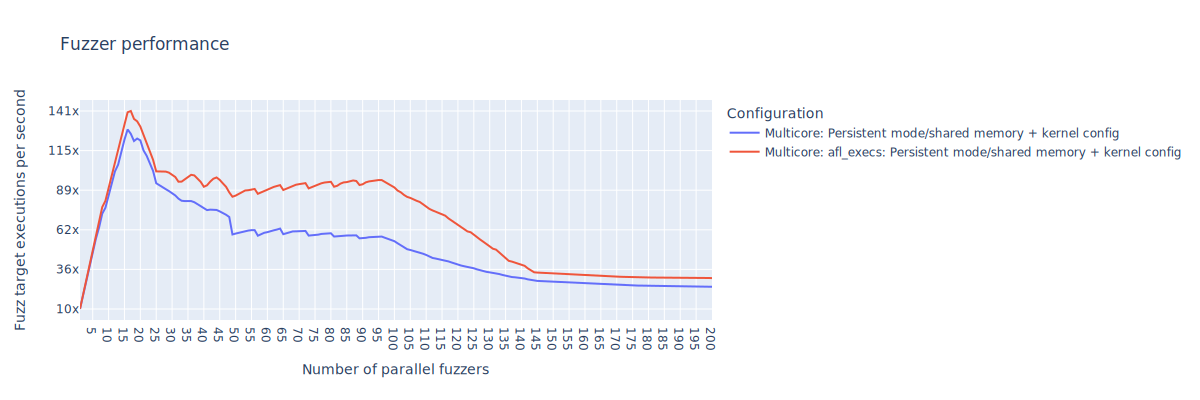

In [50]:
r6a_pivotdf = r6a_graphdf.pivot(index="parallel_fuzzers", columns="label", values="execs_per_sec")
r6a_fig = r6a_pivotdf.plot(
    title="Fuzzer performance",
    labels={
        "label": "Configuration",
        "parallel_fuzzers": "Number of parallel fuzzers",
        "value": "Fuzz target executions per second"
    }
)

# Compute tick values and their labels for the primary Y-axis
tickvals = np.linspace(r6a_graphdf['execs_per_sec'].min(), r6a_graphdf['execs_per_sec'].max(), 6)
ticktext = [f"{val:.0f}x" for val in tickvals / graphdf['execs_per_sec'].min()]
# Update the primary Y-axis with custom tick labels
r6a_fig.update_yaxes(tickvals=tickvals, ticktext=ticktext)
r6a_fig.update_xaxes(tickvals=list(range(0,200+1, 5)))
r6a_fig.update_layout(width=1200, height=400)
r6a_fig.show("svg")

### Line graph analysis

This is a shocking result for a 192 vCPU machine -- whether you count `afl_execs` or `total_execs`, our optimal number of parallel fuzzers was 16!

Does this mean that AFL++ is a bad fuzzer, or that AWS tricked us and gave us a 16-thread machine instead of a 192-thread one?

No, probably not -- the most likely causes here are a problem with our Python harness, or potentially that we're already saturating the Linux kernel's ability to service system calls, although we're definitely hitting such a limit way earlier than expected.  A good way to test this theory would be to run more system-call-servicers (read: kernels!) at once on this machine; one way to do that is to use hardware virtualization with KVM. 